In [27]:
import sys, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools
PROJECT_ROOT = pathlib.Path.cwd().parent  # LearningG2
sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: /Users/tomassilva/Desktop/GitHub/LearningG2


In [28]:
data = np.load("../sampling/g2_dataset.npz")
data.files

['base_points',
 'link_points',
 'rotations',
 'phis',
 'psis',
 'riemannian_metrics',
 'g2_metrics',
 'drop_maxs',
 'drop_ones',
 'etas']

In [29]:
# -----------------------
# Split
# -----------------------
def split_train_val_test(X, Y, train=0.90, val=0.05, seed=42):
    X = np.asarray(X, dtype=np.float32)
    Y = np.asarray(Y, dtype=np.float32)
    assert X.shape[0] == Y.shape[0]
    N = X.shape[0]

    rng = np.random.default_rng(seed)
    idx = rng.permutation(N)

    n_tr = int(train * N)
    n_va = int(val * N)
    tr = idx[:n_tr]
    va = idx[n_tr:n_tr+n_va]
    te = idx[n_tr+n_va:]

    return (X[tr], Y[tr]), (X[va], Y[va]), (X[te], Y[te])

# -----------------------
# Model
# -----------------------
def build_regressor(input_dim=19, output_dim=35, hidden=(512, 512, 256, 256), dropout=0.0):
    inp = keras.Input(shape=(input_dim,), dtype=tf.float32)

    x = inp
    for w in hidden:
        x = layers.Dense(w, activation="gelu")(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)

    out = layers.Dense(output_dim, dtype=tf.float32)(x)
    return keras.Model(inp, out)

# -----------------------
# Train
# -----------------------
def train_regressor_19_to_35(
    X, Y,
    seed=42,
    batch=2048,
    epochs=200,
    lr=1e-3,
    hidden=(512, 512, 256, 256),
    dropout=0.0
):
    (Xtr, Ytr), (Xva, Yva), (Xte, Yte) = split_train_val_test(X, Y, seed=seed)

    # Normalization layers (fit on train only)
    x_norm = layers.Normalization(axis=-1)
    y_norm = layers.Normalization(axis=-1)

    x_norm.adapt(Xtr)
    y_norm.adapt(Ytr)

    # Build model that outputs normalized Y
    base = build_regressor(input_dim=Xtr.shape[1], output_dim=Ytr.shape[1], hidden=hidden, dropout=dropout)

    inp = keras.Input(shape=(Xtr.shape[1],), dtype=tf.float32)
    x = x_norm(inp)
    yhat_norm = base(x)
    model = keras.Model(inp, yhat_norm)

    # Loss in normalized Y space
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )

    # tf.data for speed
    train_ds = tf.data.Dataset.from_tensor_slices((Xtr, y_norm(Ytr))).shuffle(
        min(len(Xtr), 200_000), seed=seed, reshuffle_each_iteration=True
    ).batch(batch).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices((Xva, y_norm(Yva))).batch(batch).prefetch(tf.data.AUTOTUNE)

    cb = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint("regressor_19_to_35.keras", monitor="val_loss", save_best_only=True),
    ]

    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb, verbose=1)

    # Predict in normalized space, then unnormalize
    Ypred_norm = model.predict(Xte, batch_size=8192, verbose=0)
    Ypred = y_norm.mean.numpy() + Ypred_norm * np.sqrt(y_norm.variance.numpy())

    return model, hist, (Xte, Yte, Ypred), (x_norm, y_norm)

# -----------------------
# Metrics + plots
# -----------------------


def plot_history(hist):
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train loss")
    plt.plot(hist.history["val_loss"], label="val loss")
    plt.yscale("log")
    plt.xlabel("epoch")
    plt.ylabel("MSE (normalized)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_true_vs_pred(Y_true, Y_pred, n_points=30000, seed=0):
    rng = np.random.default_rng(seed)
    N = Y_true.shape[0]
    idx = rng.choice(N, min(N, n_points), replace=False)
    yt = Y_true[idx].reshape(-1)
    yp = Y_pred[idx].reshape(-1)

    plt.figure(figsize=(6,6))
    plt.scatter(yt, yp, s=2, alpha=0.25)
    lo = min(yt.min(), yp.min())
    hi = max(yt.max(), yp.max())
    plt.plot([lo, hi], [lo, hi], "r--", lw=1)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def evaluate(Y_true, Y_pred):
    err = Y_pred - Y_true
    mae = np.mean(np.abs(err), axis=0)
    rmse = np.sqrt(np.mean(err**2, axis=0))

    print("Per-component MAE (min/median/max):", float(mae.min()), float(np.median(mae)), float(mae.max()))
    print("Per-component RMSE (min/median/max):", float(rmse.min()), float(np.median(rmse)), float(rmse.max()))
    print("Global MAE:", float(np.mean(np.abs(err))))
    print("Global RMSE:", float(np.sqrt(np.mean(err**2))))

In [30]:
def oriented35_components(T):
    T = np.asarray(T)
    assert T.shape == (7,7,7)
    triples = list(itertools.combinations(range(7), 3))
    vals = np.array([T[i,j,k] for (i,j,k) in triples], dtype=T.dtype)
    return vals

X = np.concatenate([data['link_points'], data['etas'], data['drop_maxs'][:,None], data['drop_ones'][:,None]], axis=1)
Y = np.array([oriented35_components(phi) for phi in data['phis']])

X.shape, Y.shape

((200000, 19), (200000, 35))

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.7262 - mae: 0.5692 - val_loss: 0.5204 - val_mae: 0.4249 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.5140 - mae: 0.4189 - val_loss: 0.4883 - val_mae: 0.4019 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.4789 - mae: 0.4000 - val_loss: 0.4320 - val_mae: 0.3711 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.4215 - mae: 0.3672 - val_loss: 0.3983 - val_mae: 0.3515 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3884 - mae: 0.3480 - val_loss: 0.3707 - val_mae: 0.3356 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3596 - mae: 0.3311 - val_loss: 0.3467 - val_mae: 0.3211 - learning_rate: 0.0010
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3359 - mae: 0.3176 - val_loss: 0.3225 - val_mae: 0.3089 - learning_rate: 0.0010
Epoch 

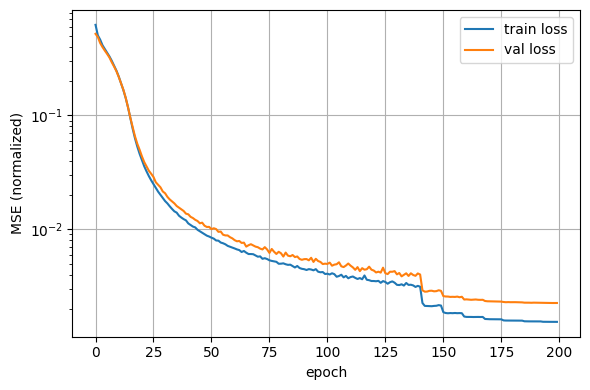

Per-component MAE (min/median/max): 0.0008105084416456521 0.0008924357243813574 0.004546438809484243
Per-component RMSE (min/median/max): 0.0013442318886518478 0.0014372622827067971 0.007043521851301193
Global MAE: 0.0018086852505803108
Global RMSE: 0.003578894305974245


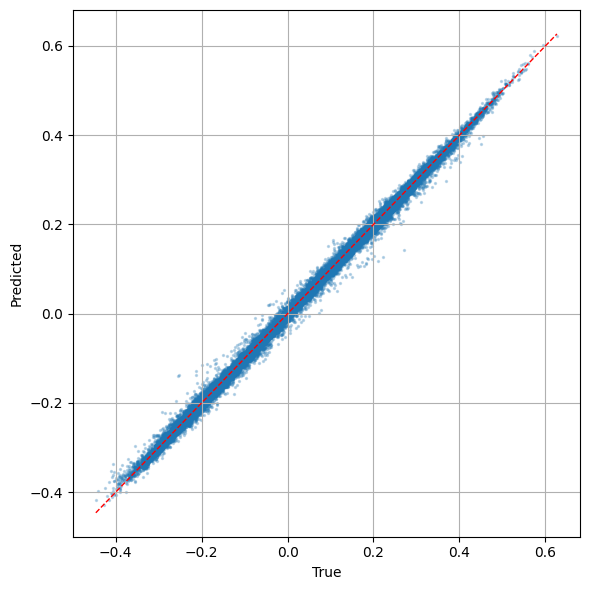

In [22]:
model, hist, (X_test, Y_test, Y_pred), norms = train_regressor_19_to_35(
    X, Y,
    batch=2048,
    epochs=200,
    lr=1e-3,
    hidden=(512, 512, 256, 256),
    dropout=0.0
)

plot_history(hist)
evaluate(Y_test, Y_pred)
plot_true_vs_pred(Y_test, Y_pred)